In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="compscismodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [11]:
bioFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [12]:
bioFOSID = bioFOSID.filter(bioFOSID["Domain"]=="Biology").collect()

In [13]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [14]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [15]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [16]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(bioFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [17]:
fos.show(2)

+--------+-------+
|  FOS_ID| Domain|
+--------+-------+
|42972112|Biology|
|97137747|Biology|
+--------+-------+
only showing top 2 rows



In [18]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [19]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [20]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [21]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [22]:
papers_filtered1.count()

6402135

In [23]:
(sample1,sample2) = papers_filtered1.randomSplit([0.2,0.8])

In [24]:
sample1.count()

1280404

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [26]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             2|
|             1|
|             0|
|             0|
+--------------+
only showing top 4 rows



In [27]:
sample1_pd = sample1.toPandas()

In [28]:
import numpy as np


In [29]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [30]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 3.254604015607574)
('Mean Squared Error of EstimatedCount:', 1095.6666880140956)
('Root Mean Squared of with EstimatedCount:', 33.10085630333595)


In [31]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [32]:
sample1_pd.shape

(1280404, 12)

In [33]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

In [34]:
sample1_pd.shape

(1280404, 12)

In [35]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [36]:
from sklearn.model_selection import KFold

In [37]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 2.802645622499216)
('Mean Squared Error:', 435.7349387172539)
('Root Mean Squared Error:', 20.87426498627566)
('Mean Absolute Error:', 4.071754597422298)
('Mean Squared Error:', 571.7004412736337)
('Root Mean Squared Error:', 23.910258076265794)
('Mean Absolute Error:', 3.7554703742443865)
('Mean Squared Error:', 326.37434969908907)
('Root Mean Squared Error:', 18.06583376706121)
('Mean Absolute Error:', 2.180909030563214)
('Mean Squared Error:', 272.293629862328)
('Root Mean Squared Error:', 16.501322064074987)
('Mean Absolute Error:', 2.6176358130600885)
('Mean Squared Error:', 429.1158968999652)
('Root Mean Squared Error:', 20.71511276580374)


In [40]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 20.013358331896278)


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
featureslist=sample1_pd.columns

In [43]:
importances = regressor.feature_importances_

In [44]:
import pandas as pd

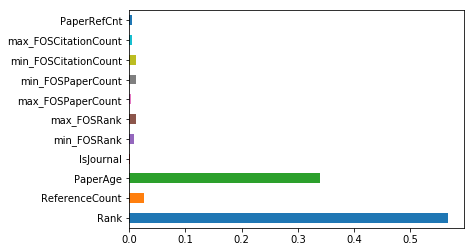

In [45]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model

In [46]:
import xgboost as xgb

In [47]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [48]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 256081,  256082,  256083, ..., 1280401, 1280402, 1280403]), 'TEST:', array([     0,      1,      2, ..., 256078, 256079, 256080]))
('Mean Absolute Error of XGBoost Kfold:', 2.8534882090194316)
('Mean Squared Error of XGBoost Kfold:', 458.91986370259417)
('Root Mean Squared Error of XGBoost Kfold:', 21.422414982970388)
('TRAIN:', array([      0,       1,       2, ..., 1280401, 1280402, 1280403]), 'TEST:', array([256081, 256082, 256083, ..., 512159, 512160, 512161]))
('Mean Absolute Error of XGBoost Kfold:', 4.265856808125113)
('Mean Squared Error of XGBoost Kfold:', 622.1351503090061)
('Root Mean Squared Error of XGBoost Kfold:', 24.94263719635528)
('TRAIN:', array([      0,       1,       2, ..., 1280401, 1280402, 1280403]), 'TEST:', array([512162, 512163, 512164, ..., 768240, 768241, 768242]))
('Mean Absolute Error of XGBoost Kfold:', 3.9219685891657328)
('Mean Squared Error of XGBoost Kfold:', 429.7044513409688)
('Root Mean Squared Error of XGBoost Kfold:', 20.7293

In [53]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 21.817939542179865)


In [54]:
importances = regressor.feature_importances_

In [55]:
import pandas as pd

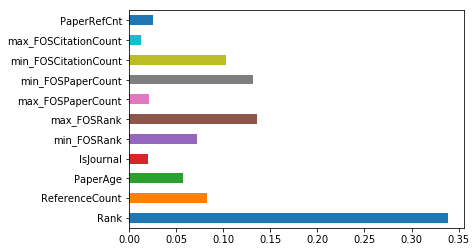

In [56]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 